In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches

In [3]:
import sys 
sys.path.append('../../src')

from spaceoracle.visionary import Visionary
from spaceoracle.plotting.cartography import xy_from_adata
from spaceoracle.plotting.cartography import Cartography


2025-05-02 10:35:03.388410: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/gcc-12.2.0/postgresql/15.2/lib:/ihome/crc/install/gcc-12.2.0/imagemagick/6.9.12/lib:/ihome/crc/install/gcc-12.2.0/geos/3.9.4/lib:/ihome/crc/install/gcc-12.2.0/zstd/zstd-1.5.5/lib:/ihome/crc/install/gcc-12.2.0/unixodbc/2.3.11/lib:/ihome/crc/install/sodium/1.0.18/lib:/ihome/crc/install/gcc-12.2.0/r/4.4.0/lib64/R/lib:/ihome/crc/install/gcc-12.2.0/openmpi/4.1.5/lib:/ihome/crc/install/gcc-12.2.0/fftw/3.3.10/lib:/ihome/crc/install/gcc-12.2.0/glpk/5.0/lib:/ihome/crc/install/gcc-12.2.0/proj/4.9.3/lib:/ihome/crc/install/gcc-12.2.0/gdal/2.4.4/lib:/ihome/crc/install/gcc-12.2.0/netcdf/4.8.1/lib:/ihome/crc/install/gcc-12.2.0/hdf5/1.14.0/lib:/ihome/crc/install/gcc-12.2.0/jags/4.3.2/lib:/ihome/crc/install/gcc-12.2.0/gsl/2.7.1/lib:/ihome/c

In [4]:
ref_adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_kidney_13.h5ad')
ref_models_dir = '/ix/djishnu/shared/djishnu_kor11/lasso_runs/mouse_kidney_13'

ref_adata

AnnData object with n_obs × n_vars = 8509 × 3058
    obs: 'ct1', 'ct2', 'ct3', 'ct4', 'cond', 'medulla_cortex', 'domain', 'cell_type', 'cell_type_int'
    uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'pca', 'received_ligands', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

In [5]:
test_adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_kidney_visiumHD_subsampled.h5ad')
test_adata

AnnData object with n_obs × n_vars = 10000 × 3058
    obs: 'ct3', 'cell_type', 'x', 'y', 'banksy_cluster', 'x_umap', 'y_umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [6]:
labels = pd.read_csv('figures/dfs/mouse_kidney_visium_leiden_markers.csv', index_col=0)
adata = test_adata[labels.index, :]
adata.obs['leiden'] = labels['leiden'].astype(int)
adata



/tmp/ipykernel_59623/1822614451.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['leiden'] = labels['leiden'].astype(int)


AnnData object with n_obs × n_vars = 2552 × 3058
    obs: 'ct3', 'cell_type', 'x', 'y', 'banksy_cluster', 'x_umap', 'y_umap', 'leiden'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'spatial'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [7]:
adata_subset = adata[adata.obs['leiden']!=2]
adata_subset.obs['leiden'].to_csv('figures/dfs/mouse_kidney_visium_leiden_y.csv')

x = adata_subset.to_df(layer='normalized_count')
x.loc[:, x.var() != 0].to_csv('figures/dfs/mouse_kidney_visium_leiden_X.csv')

In [8]:
adata.obs['leiden'] = adata.obs['leiden'].astype(str).astype('category')
adata_subset = adata[adata.obs['leiden'].isin(['0', '1'])].copy()

sc.tl.rank_genes_groups(adata_subset, groupby='leiden', method='t-test', groups=['0'], reference='1', layer='normalized_count')
degs = sc.get.rank_genes_groups_df(adata_subset, group='0')
print(degs)


        names     scores  logfoldchanges          pvals      pvals_adj
0        Gpx3  40.973366        5.751681  3.392560e-272  1.037445e-268
1         Kap  36.195301        5.192060  2.674844e-227  4.089836e-224
2     Slc27a2  27.683798        4.924446  2.367390e-136  1.809870e-133
3       Aldob  27.622992        5.264974  5.054081e-134  3.091076e-131
4       Acsm2  25.203154        5.359048  1.726209e-114  8.797914e-112
...       ...        ...             ...            ...            ...
3053      Egf -16.184814       -3.400833   3.227418e-55   4.486111e-53
3054   Slc5a3 -16.488972       -5.826136   5.823113e-56   8.479562e-54
3055  Wfdc15b -18.876480       -4.603475   6.777709e-72   1.594326e-69
3056  Slc12a1 -22.346741       -5.336813   6.909543e-96   2.112938e-93
3057     Umod -30.351297       -4.782572  9.176826e-169  9.354244e-166

[3058 rows x 5 columns]


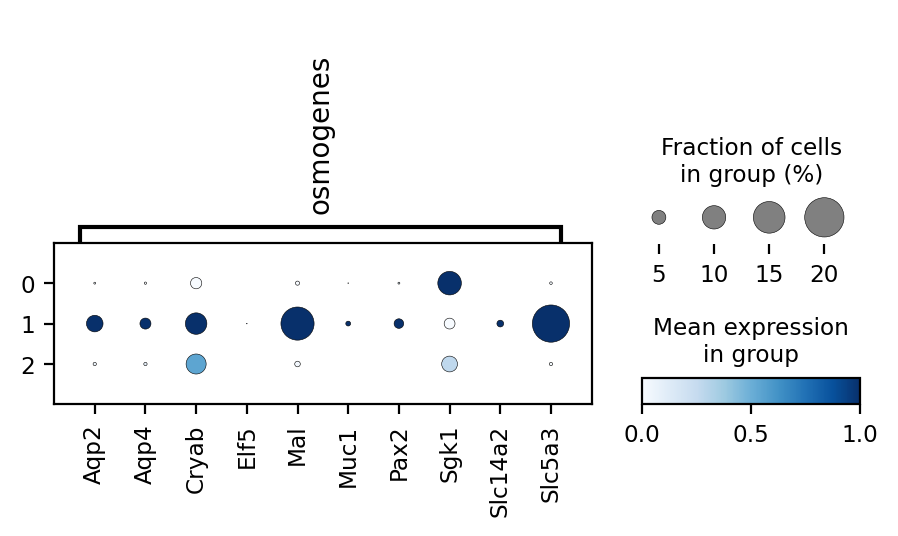

In [9]:
adata.obs['leiden'] = labels['leiden'].astype('category')

marker_genes = {
    # 'M1': ['Il1b', 'Tnf', 'Ccl2', 'Cd86'],
    # 'M2': ['Arg1', 'Mrc1', 'Il10', 'Cd163'],
    'osmogenes': ['Aqp2', 'Aqp4', 'Cryab', 'Elf5', 'Mal', 'Muc1',
        'Pax2', 'Sgk1', 'Slc14a2', 'Slc5a3'],
}

sc.pl.dotplot(
    adata,
    var_names=marker_genes,
    groupby='leiden',
    standard_scale='var',
    cmap='Blues'
)


In [5]:
# matching = pd.read_csv('matching_slat.csv', index_col=0)
matching = pd.read_csv('matching_slat_banksy_subsampled.csv', index_col=0)
matching.head(3)

,reference_cell
ID_167606,AGTACTGTCACTTATC-13
ID_103875,CTACCCACAGACGGAT-13
ID_276156,CAACAGTCATAACTCG-13


In [6]:
matching['cell_type'] = matching['reference_cell'].map(ref_adata.obs['cell_type'])
matching['ct3'] = matching['reference_cell'].map(ref_adata.obs['ct3'])
matching.head(3)

,reference_cell,cell_type,ct3
ID_167606,AGTACTGTCACTTATC-13,Myeloid,Mac_2
ID_103875,CTACCCACAGACGGAT-13,Epithelial,Epithelial_TALH_1
ID_276156,CAACAGTCATAACTCG-13,Myeloid,Mac_2


In [7]:
test_adata.obs = matching

In [8]:
ref_adata, test_adata

(AnnData object with n_obs × n_vars = 8509 × 3058
     obs: 'ct1', 'ct2', 'ct3', 'ct4', 'cond', 'medulla_cortex', 'domain', 'cell_type', 'cell_type_int'
     uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'pca', 'received_ligands', 'received_ligands_tfl', 'umap'
     obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
     varm: 'PCs'
     layers: 'imputed_count', 'normalized_count', 'raw_count'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 10000 × 3058
     obs: 'reference_cell', 'cell_type', 'ct3'
     obsm: 'X_harmony', 'X_pca', 'X_umap', 'spatial'
     layers: 'imputed_count', 'normalized_count', 'raw_count')

In [9]:
colors = ["#9ac54f",
"#8146b8",
"#87b997",
"#c45183",
"#4c3c3a",
"#c46f41",
"#8d93c1"]

color_dict = {
    ct: color for ct, color in zip(ref_adata.obs['cell_type'].unique(), colors)
}

In [11]:
chart_ref = Cartography(ref_adata, color_dict)
chart_test = Cartography(test_adata, color_dict)

In [12]:
betadata_dir='/ix/djishnu/shared/djishnu_kor11/genome_screens'

chart_ref.load_perturbation('Mif', f'{betadata_dir}/mouse_kidney_13') 
chart_test.load_perturbation('Mif', f'{betadata_dir}/mouse_kidney_visiumHD_subsampled') 

In [ ]:
ref_corr = chart_ref.get_corr('Mif')
test_corr = chart_test.get_corr('Mif')

In [ ]:
celltypes = set(ref_adata.obs['cell_type'].unique()) & set(test_adata.obs['cell_type'].unique())
celltypes

In [ ]:
from tqdm import tqdm

ref_kos = {}
test_kos = {}

for ct in tqdm(celltypes):
    ref_kos[ct] = chart_ref.compute_transitions(ref_corr, source_ct=ct, annot='cell_type')
    test_kos[ct] = chart_test.compute_transitions(test_corr, source_ct=ct, annot='cell_type')



### Spatial mapping

In [32]:
matching['x'] = pd.Series(test_adata.obsm['spatial'][:, 0], index=matching.index)
matching['y'] = pd.Series(test_adata.obsm['spatial'][:, 1], index=matching.index)
matching.head(3)


,reference_cell,cell_type,ct3,x,y
ID_167606,TGAGCATTCGTCGATA-13,Myeloid,Mac_0,20646.342233,13577.402528
ID_276156,CAACAGTCATAACTCG-13,Myeloid,Mac_2,26279.892415,19862.586445
ID_169310,TACGCTCGTGCCTGAC-13,Myeloid,Mac_2,22664.227129,12878.601577


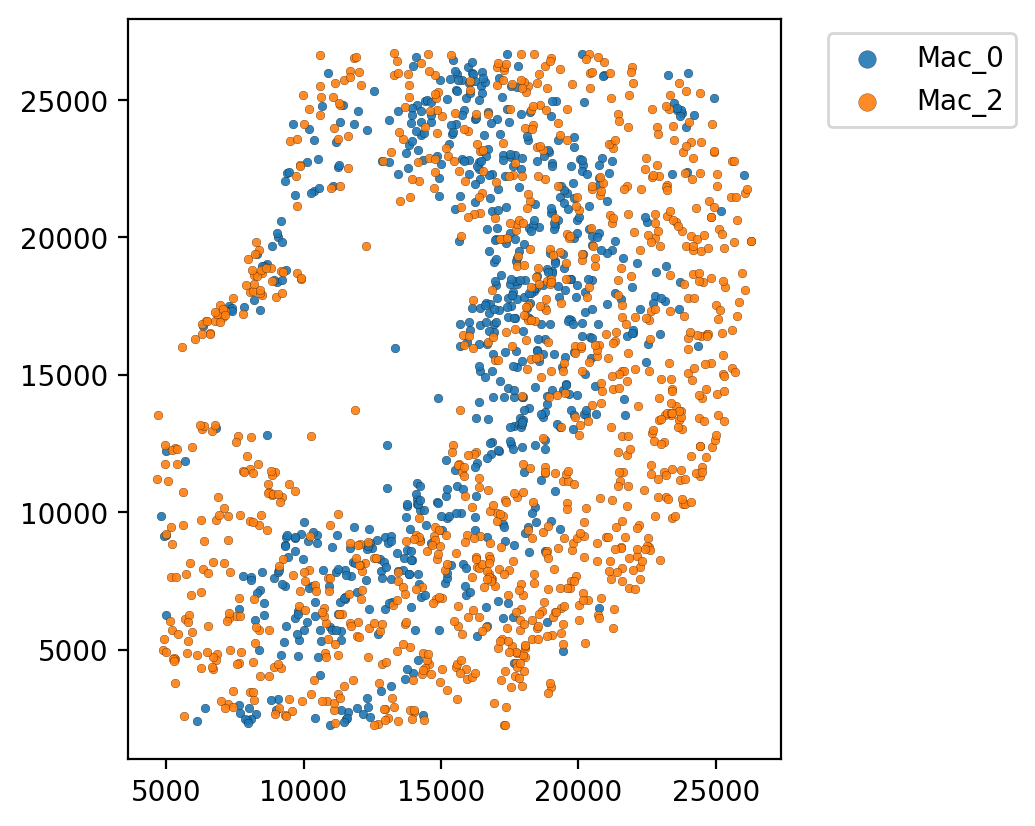

In [33]:
for ct3 in ['Mac_0', 'Mac_2']:
    plt.scatter(matching[matching['ct3'] == ct3]['x'],
                matching[matching['ct3'] == ct3]['y'],
                label=ct3,
                alpha=0.9, edgecolor='black', linewidth=0.1,
                s=10)
plt.gca().set_aspect('equal')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=2)
plt.show()

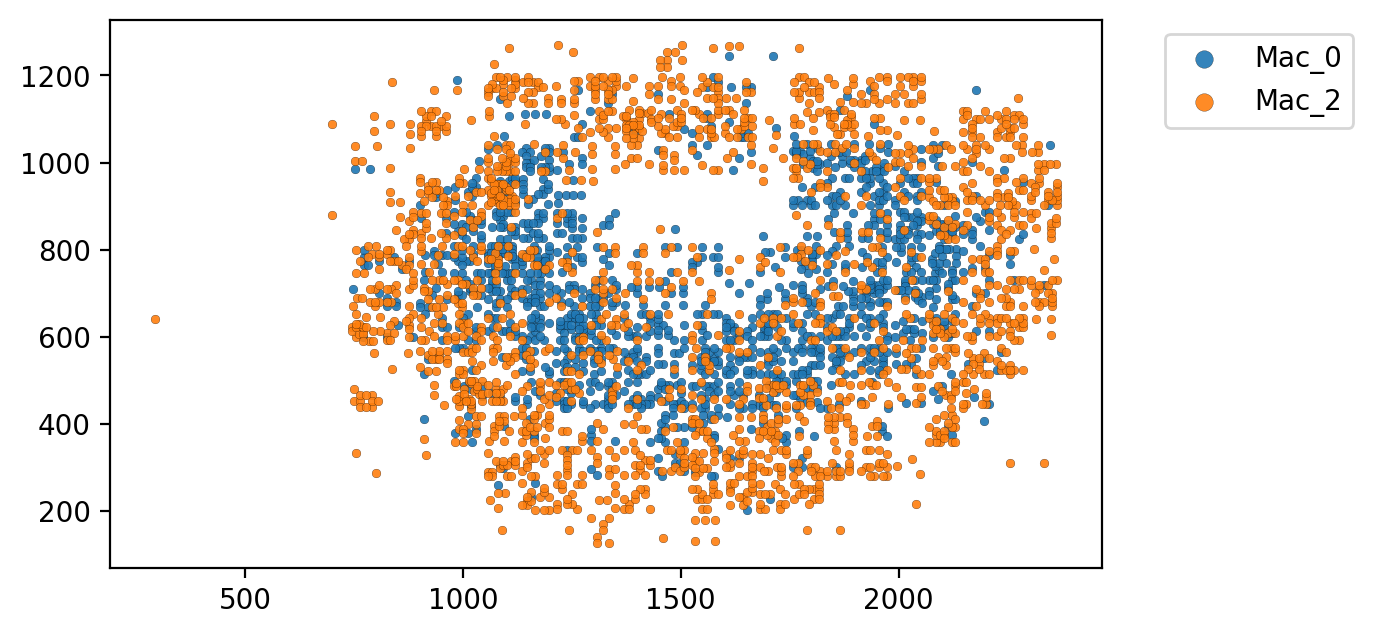

In [34]:
for ct3 in ['Mac_0', 'Mac_2']:
    plt.scatter(ref_adata.obsm['spatial'][ref_adata.obs['ct3'] == ct3, 0],
                ref_adata.obsm['spatial'][ref_adata.obs['ct3'] == ct3, 1],
                label=ct3,
                alpha=0.9, edgecolor='black', linewidth=0.1,
                s=10)
plt.gca().set_aspect('equal')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=2)
plt.show()

In [35]:
matching

,reference_cell,cell_type,ct3,x,y
ID_167606,TGAGCATTCGTCGATA-13,Myeloid,Mac_0,20646.342233,13577.402528
ID_276156,CAACAGTCATAACTCG-13,Myeloid,Mac_2,26279.892415,19862.586445
ID_169310,TACGCTCGTGCCTGAC-13,Myeloid,Mac_2,22664.227129,12878.601577
ID_139089,TCACAAGCAAATCCCA-13,Myeloid,Mac_2,7931.237086,12048.729027
ID_168490,GCGGATCCATCTAACG-13,Myeloid,Mac_0,20267.389953,13539.575270
...,...,...,...,...,...
ID_135335,GGTTGTATCGACGATT-13,Myeloid,Mac_2,10268.177393,12778.959819
ID_33301,TCATCATAGTTCGGTT-13,Myeloid,Mac_2,17192.757516,3884.367069
ID_310325,GAAGGACCAAATGCGG-13,Myeloid,Mac_2,21814.626680,24008.442453
ID_314503,CAACAGTCATAACTCG-13,Myeloid,Mac_2,26142.238248,21763.799487


In [36]:
ref_adata = ref_adata[ref_adata.obs['ct3'].isin(['Mac_0', 'Mac_2'])]
ref_adata

View of AnnData object with n_obs × n_vars = 3237 × 3058
    obs: 'ct1', 'ct2', 'ct3', 'ct4', 'cond', 'medulla_cortex', 'domain', 'cell_type', 'cell_type_int'
    uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'pca', 'received_ligands', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

In [37]:
genome_dirs = '/ix/djishnu/shared/djishnu_kor11/genome_screens'
ref_dir = f'{genome_dirs}/mouse_kidney_13'
test_dir = f'{genome_dirs}/mouse_kidney_visiumHD_subsampled'

In [38]:
target = 'Mif'
gex_df = pd.read_parquet(f'{test_dir}/{target}_4n_0x.parquet')
test_adata.layers[target] = gex_df.reindex(test_adata.obs.index).reindex(test_adata.var.index, axis=1).values

gex_df = pd.read_parquet(f'{ref_dir}/{target}_4n_0x.parquet')
ref_adata.layers[target] = gex_df.reindex(ref_adata.obs.index).reindex(ref_adata.var.index, axis=1).values

/tmp/ipykernel_59009/3027970013.py:3: ImplicitModificationWarning: Setting element `.layers['Mif']` of view, initializing view as actual.
  test_adata.layers[target] = gex_df.reindex(test_adata.obs.index).reindex(test_adata.var.index, axis=1).values
/tmp/ipykernel_59009/3027970013.py:6: ImplicitModificationWarning: Setting element `.layers['Mif']` of view, initializing view as actual.
  ref_adata.layers[target] = gex_df.reindex(ref_adata.obs.index).reindex(ref_adata.var.index, axis=1).values


In [40]:
test_adata.obs = matching

In [41]:
from spaceoracle.plotting.cartography import Cartography

chart_test = Cartography(
    adata = test_adata,
    color_dict = color_dict
)

chart_ref = Cartography(
    adata = ref_adata,
    color_dict = color_dict
)


In [42]:
corr_mtx_test = chart_test.get_corr(target)
corr_mtx_ref = chart_ref.get_corr(target)

In [43]:
from numba import jit

# Cannibalized from CellOracle
@jit(nopython=True)
def permute_rows_nsign(A: np.ndarray) -> None:
    """Permute in place the entries and randomly switch the sign for each row of a matrix independently.
    """
    plmi = np.array([+1, -1])
    for i in range(A.shape[0]):
        np.random.shuffle(A[i, :])
        A[i, :] = A[i, :] * np.random.choice(plmi, size=A.shape[1])


In [44]:
delta_X_rndm = (chart_test.adata.to_df(layer=target) - chart_test.unperturbed_expression).values
permute_rows_nsign(delta_X_rndm)

corr_mtx_test_rand = chart_test.compute_perturbation_corr(
    chart_test.unperturbed_expression.values, delta_X_rndm)

In [58]:
delta_X_rndm = (chart_ref.adata.to_df(layer=target) - chart_ref.unperturbed_expression).values
permute_rows_nsign(delta_X_rndm)

corr_mtx_ref_rand = chart_ref.compute_perturbation_corr(
    chart_ref.unperturbed_expression.values, delta_X_rndm)

In [ ]:
transition_test = chart_test.compute_transitions(
    corr_mtx = corr_mtx_test,
    source_ct = 'Mac_0',
    # annot = 'ct3',
    annot = 'banksy_cluster'
)

transition_test_rand = chart_test.compute_transitions(
    corr_mtx = corr_mtx_test_rand,
    source_ct = 'Mac_0',
    # annot = 'ct3'
    annot = 'banksy_cluster'
)

In [59]:
transition_ref = chart_ref.compute_transitions(
    corr_mtx = corr_mtx_ref,
    source_ct = 'Mac_0',
    annot = 'ct3'
)

transition_ref_rand = chart_ref.compute_transitions(
    corr_mtx = corr_mtx_ref_rand,
    source_ct = 'Mac_0',
    annot = 'ct3'
)



In [54]:
thresh = 0.00045 # need to cross this to leave base cell phenotype

In [55]:
_ = chart_test.get_cellfate(transition_test_rand, ['Mac_0', 'Mac_2'], thresh=thresh, annot='ct3')

Counter({'Mac_0': 348, 'Mac_2': 328}) 0.0005954320467062465


In [56]:
_ = chart_test.get_cellfate(transition_test, ['Mac_0', 'Mac_2'], thresh=thresh, annot='ct3')

Counter({'Mac_0': 646, 'Mac_2': 30}) 0.000604543174522646


In [60]:
_ = chart_ref.get_cellfate(transition_ref_rand, ['Mac_0', 'Mac_2'], thresh=thresh, annot='ct3')

Counter({'Mac_0': 1385}) 0.00031386447329981787


In [57]:
_ = chart_ref.get_cellfate(transition_ref, ['Mac_0', 'Mac_2'], thresh=thresh, annot='ct3')

Counter({'Mac_0': 872, 'Mac_2': 513}) 0.0004417222721300365


In [41]:
adata_ = test_adata
kotarget = 'Mif'

In [42]:
from spaceoracle.plotting.shift import estimate_transition_probabilities

embedding = adata_.obsm['X_umap']
n_neighbors = 200
delta_X = adata_.layers[kotarget] - adata_.layers['imputed_count']
P = estimate_transition_probabilities(
    adata_, delta_X, embedding, n_neighbors=n_neighbors, n_jobs=1)

delta_X_null = adata_.layers['imputed_count'] - adata_.layers['imputed_count']
P_null = estimate_transition_probabilities(
    adata_, delta_X_null, embedding, n_neighbors=n_neighbors, n_jobs=1)

In [49]:
adata_

AnnData object with n_obs × n_vars = 4726 × 3058
    obs: 'ct3', 'cell_type', 'ct3', 'cell_type', 'x', 'y', 'banksy_cluster', 'ref_ct3', 'ref_cell_type', 'x_umap', 'y_umap'
    uns: 'T_fwd_params'
    obsm: 'X_pca', 'X_umap', 'spatial', 'T_fwd_spatial', 'X_spatial', 'T_fwd_umap'
    layers: 'imputed_count', 'normalized_count', 'raw_count', 'Mif'
    obsp: '_shift'

In [ ]:
adata_.obsp['_shift'] = P.copy()

In [ ]:
import cellrank as cr

ck = cr.kernels.ConnectivityKernel(adata_, conn_key='_shift')
ck.compute_transition_matrix(density_normalize=True)

ConnectivityKernel[n=4726, dnorm=True, key='_shift']

In [ ]:
adata_.obs['ref_ct3_int'] = [int(ct.split('_')[1]) for ct in adata_.obs['ref_ct3']]
adata_.obs['ref_ct3_int'].value_counts()

ref_ct3_int
2    2637
0    2089
Name: count, dtype: int64

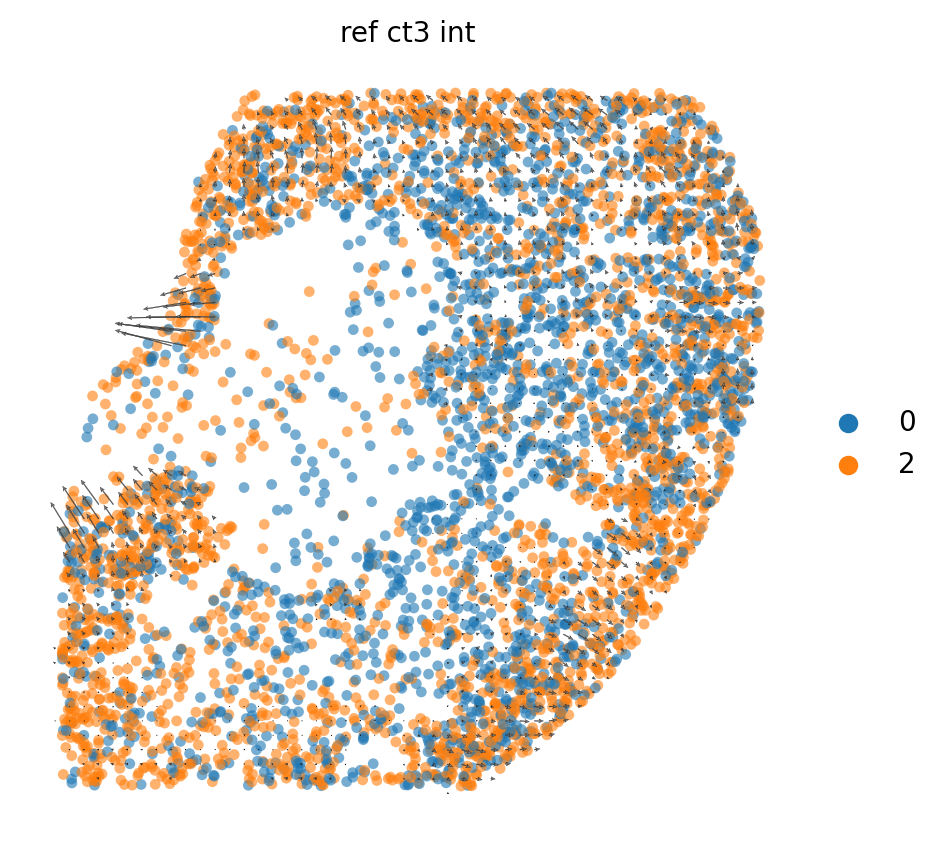

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
projection_params = {
    'basis': 'spatial',
    'color': 'ref_ct3_int', 
    'legend_loc': 'right',
    'recompute': True,
    'stream': False,
    'scale': 1,
    'alpha': 0.6,
    'size': 60,
    'show': False,
    'linewidth': 0.1,
    # 'palette': color_dict,
    'min_mass': 50,
    'smooth': 1.5,
    'autoscale': True,
    'ax': ax
}
ax.set_aspect('equal')
ck.plot_projection(**projection_params)